In [1]:
import os
from multiprocessing import Pool
from itertools import product
import json


import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Consts

ITEM_FEATURES = {
    "score": "model_scores/scores_train.bin",
    "rank": "item_train_ranks.bin",
    "log_rank": "item_train_log_ranks.bin"
}

build_cmd_template = (
    "./RPG --mode base --baseSize 1000000 --trainQueries 1000 "
    "--base data/{dataset}/data/{itemFeatures} "
    "--outputGraph {graphPath} "
    "--relevanceVector {relevanceVector} --efConstruction {efConstruction} --M 8 "
    "--itemRanks data/{dataset}/data/item_train_ranks.bin "
    "--ranksToDist data/{dataset}/data/rankToDist.bin "
    "--metric {metricType}"
)

search_cmd_template = (
    "./RPG --mode query --baseSize 1000000 --querySize 1000"
    " --query data/{dataset}/data/model_scores/scores_{datasetPart}.bin --inputGraph {inputGraph}"
    " --efSearch {efSearch} --topK 5 --output data/{dataset}/result.txt --gtQueries 1000 --gtTop 100 "
    "--groundtruth data/{dataset}/data/model_scores/{groundtruth}.bin"
)

In [3]:
# exp config

# METRIC_PARAMS = list(product(["l1", "l2"], ["score", "rank", "log_rank"])) + [("min_sum", "rank")]
# METRIC_PARAMS = [("min_sum", "rank")]
METRIC_PARAMS = [
#     ("top_sum --sumOrd 0", "rank"),
#     ("top_sum --sumOrd 1", "rank"),
#     ("top_sum --sumOrd 2", "rank"),
#     ("top_sum --sumOrd 5", "rank"),
#     ("top_sum --sumOrd 10", "rank"),
#     ("top_sum --sumOrd 20", "rank"),
#     ("top_sum --sumOrd 50", "rank"),
#     ("top_sum --sumOrd 100", "rank"),
#     ("top_sum --sumOrd 200", "rank"),
#     ("min_sum", "rank"),
    ("l2", "score"),
#     ("l2", "rank"),
#     ("l2", "log_rank"),
#     ("hybrid --D 100", "score"),
#     ("hybrid --D 50", "score"),
#     ("hybrid --D 20", "score"),
#     ("hybrid --D 10", "score"),
#     ("hybrid --D 5", "score"),
#     ("l1", "score"),
#     ("l1", "rank"),
#     ("l1", "log_rank")
]

dataset = "collections"
dataset_part = "test"
efConstruction = 1000
relevanceVector = 1000 # length of relevance vector
efSearchTicks = list(np.exp(np.linspace(np.log(10), np.log(10000), 16)).astype("int"))
n_search_threads = 8

assert dataset_part in ["train", "test"]

In [4]:
def bench_cmd(cmd):
    res = {}
    with os.popen(cmd) as out:
        for line in out:
            for stat_name, prefix, suff_len in [
                ("relevance", "Average relevance: ", 1),
                ("recall", "Recall@5: ", 1),
                ("time", "Average query time: ", 3),
                ("evals", "Average number of model computations: ", 1)
            ]:
                if line.startswith(prefix):
                    res[stat_name] = float(line[len(prefix):-suff_len])
    return res

def measure_performance(graph, dataset, ef_ticks, n_threads=8):
    commands = []
    for ef in ef_ticks:
        commands.append(search_cmd_template.format(
            inputGraph=graph,
            dataset=dataset,
            efSearch=ef,
            datasetPart=dataset_part,
            groundtruth="groundtruth" if dataset_part == "test" else "groundtruth_train"
        ))
    pool = Pool(processes=n_threads)
    results = pool.map(bench_cmd, commands)
    output = {"relevance": [], "recall": [], "time": [], "evals": []}
    for i, res in enumerate(results):
        if all(key in res for key in output):
            for key in output:
                output[key].append(res[key])
        else:
            print("missed result for {} efSearch {}.".format(graph, ef_ticks[i]))
    return output

In [5]:
def get_graph_label(metric_type, feature_type):
    return metric_type.replace(" ", "_").replace("-", "") + "_" + feature_type

In [6]:
# build graphs
for metric_type, feature_type in METRIC_PARAMS:
    # build graph
    graph_path = "data/{}/{}_graph_rel{}ef{}.out".format(
        dataset, get_graph_label(metric_type, feature_type),
        relevanceVector, efConstruction
    )
    if not os.path.isfile(graph_path):
        build_cmd = build_cmd_template.format(
            graphPath=graph_path,
            dataset=dataset,
            itemFeatures=ITEM_FEATURES[feature_type],
            efConstruction=efConstruction,
            relevanceVector=relevanceVector,
            metricType=metric_type
        )
        print(build_cmd)
        os.system(build_cmd)
        print("Graph for {} metric and {} features is built".format(metric_type, feature_type))
        print()

In [7]:
exp_id = "rel{}ef{}_{}".format(relevanceVector, efConstruction, dataset_part)
result_path = "data/{}/data/results/{}.json".format(dataset, exp_id)
if os.path.isfile(result_path):
    with open(result_path) as fin:
        results = json.load(fin)
else:
    results = {}

for metric_type, feature_type in METRIC_PARAMS:
    graph_label = get_graph_label(metric_type, feature_type)
    graph_path = "data/{}/{}_graph_rel{}ef{}.out".format(
        dataset, graph_label,
        relevanceVector, efConstruction
    )
    if (
        graph_label not in results or
        len(results[graph_label]["recall"]) < len(efSearchTicks)
    ):
        results[graph_label] = measure_performance(graph_path, dataset, efSearchTicks, n_threads=n_search_threads)

In [8]:
def read_txt(file_name):
    data = []
    with open(file_name) as fin:
        for line in fin:
            data.append([int(w) for w in line.split()])
    return data

def calc_eval_recall_curve(approximate_top, gt_top):
    query_count = 1000
    recall_top_len = 5
    assert gt_top.shape == (query_count, recall_top_len)
    assert len(approximate_top) == query_count
    
    gt_tops = [set(query_top) for query_top in gt_top]
    recalls = []
    found_count = 0
    top_len = max(len(l) for l in approximate_top)
    for i in range(top_len):
        for query_id in range(query_count):
            if (
                i < len(approximate_top[query_id]) and
                approximate_top[query_id][i] in gt_tops[query_id]
            ):
                found_count += 1
        recalls.append(found_count / (query_count * recall_top_len))
    evals = list(range(1, top_len + 1))
    return {"evals": evals, "recall": recalls}

def eval_two_tower(graph_path, scores_file, gt_file, gt_top_len):
    _, graph_name = os.path.split(graph_path)
    graph_name, _ = os.path.splitext(graph_name)
    result_path = "data/{}/{}_result_{}.txt".format(dataset, graph_name, gt_top_len)
    search_cmd = (
        "./RPG --mode query --baseSize 1000000 --querySize 1000 "
        "--query data/{dataset}/data/model_scores/{scoresFile} --inputGraph {inputGraph} "
        "--efSearch {gtTop} --topK {gtTop} --output {resultPath} "
        "--gtQueries 1000 --gtTop {gtTop} "
        "--groundtruth data/{dataset}/data/model_scores/{gtFile}"
    ).format(
        dataset=dataset, scoresFile=scores_file, inputGraph=graph_path,
        gtTop=gt_top_len, resultPath=result_path, gtFile=gt_file
    )
    print(search_cmd)
    os.system(search_cmd)

    approximate_top = read_txt(result_path)
    gt = np.fromfile(
        "data/{}/data/model_scores/{}".format(dataset, gt_file),
        dtype="int32"
    ).reshape((1000, gt_top_len))
    gt = gt[:,:5]
    return calc_eval_recall_curve(approximate_top, gt)

    

In [34]:
# build graph on embeddings
for metric in ["l2"]:
    embed_graph_path = "data/{}/embed_{}_graph.out".format(dataset, metric)
    if not os.path.isfile(embed_graph_path):
        build_embed_graph_cmd = (
            "./RPG --mode base --baseSize 1000000 --trainQueries 50 "
            "--base data/{dataset}/data/item_embeddings.bin "
            "--outputGraph {graphPath} "
            "--relevanceVector 50 --efConstruction 1000 --M 8 "
            "--metric {metric}"
        ).format(dataset=dataset, graphPath=embed_graph_path, metric=metric)
        print(build_embed_graph_cmd)
        os.system(build_embed_graph_cmd)
    
    label = "embed_{}_rerank".format(metric)
    results[label] = eval_two_tower(
        embed_graph_path,
        "embedding_scores_test.bin",
        "groundtruth_test_10000.bin",
        10000
    )
        
    label = "embed_{}_search_cb".format(metric)
    results[label] = measure_performance(embed_graph_path, dataset, efSearchTicks, n_threads=n_search_threads)
        
    

./RPG --mode query --baseSize 1000000 --querySize 1000 --query data/collections/data/model_scores/embedding_scores_test.bin --inputGraph data/collections/embed_l2_graph.out --efSearch 10000 --topK 10000 --output data/collections/embed_l2_graph_result_10000.txt --gtQueries 1000 --gtTop 10000 --groundtruth data/collections/data/model_scores/groundtruth_test_10000.bin


In [35]:
l2_score_graph_path = "data/collections/l2_score_graph_rel1000ef1000.out"
label = "l2_score_search_embed"
results[label] = eval_two_tower(
    l2_score_graph_path,
    "embedding_scores_test.bin",
    "groundtruth_test_10000.bin",
    10000
)


./RPG --mode query --baseSize 1000000 --querySize 1000 --query data/collections/data/model_scores/embedding_scores_test.bin --inputGraph data/collections/l2_score_graph_rel1000ef1000.out --efSearch 10000 --topK 10000 --output data/collections/l2_score_graph_rel1000ef1000_result_10000.txt --gtQueries 1000 --gtTop 10000 --groundtruth data/collections/data/model_scores/groundtruth_test_10000.bin


In [30]:
with open(result_path, "w") as fout:
    json.dump(results, fout, indent=4)

In [31]:
def plot_chosen_results(results, keys, xlim=None, ylim=None, x_log_scale=False):
    plt.figure(figsize=(10, 10))
    plt.xlabel("evals")
    plt.ylabel("recall@5")
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if x_log_scale:
        plt.xscale("log")
    
    for key in keys:
        assert key in results
        r = results[key]
        x = r["evals"]
        y = r["recall"]
        plt.plot(x, y, label=key)
        pt_size = 0.1 if len(x) > 100 else 10
        plt.scatter(x, y, s=pt_size)
    plt.legend()
    plt.show()

In [24]:
def plot_results(results, x_data="evals", y_data="recall"):
    plt.xlabel(x_data)
    plt.ylabel(y_data)
#     plt.xlim([1000, 20000])
    plt.ylim([0.8, 1])
    plt.xscale('log')
#     plt.yscale('log')
    for metric_type, feature_type in METRIC_PARAMS:
        label = get_graph_label(metric_type, feature_type)
        stats = results[label]
        plt.plot(stats[x_data], stats[y_data], label=label)
        plt.scatter(stats[x_data], stats[y_data], s=10)
    plt.legend()
    plt.show()

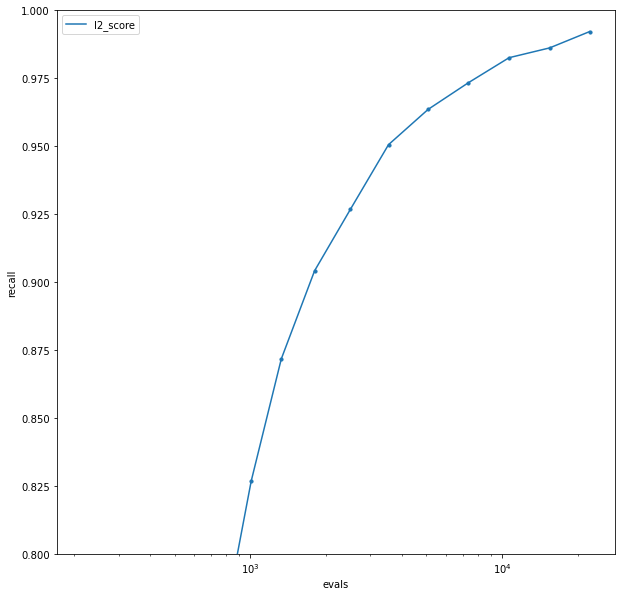

In [25]:
plt.figure(figsize=(10, 10))
plot_results(results)

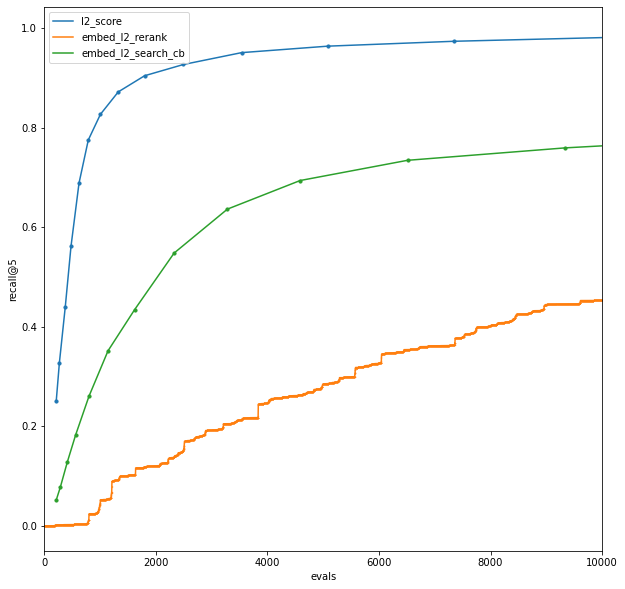

In [36]:
plot_chosen_results(results, [
    "l2_score",
    "embed_l2_rerank",
    "embed_l2_search_cb",
#     "l2_score_search_embed"
], xlim=(0, 10000))

In [78]:
list(results.keys())

['top_sum_sumOrd_0_rank',
 'top_sum_sumOrd_1_rank',
 'top_sum_sumOrd_2_rank',
 'top_sum_sumOrd_5_rank',
 'l2_score',
 'l2_rank',
 'l2_log_rank',
 'hybrid_D_100_score',
 'hybrid_D_50_score',
 'hybrid_D_20_score',
 'hybrid_D_10_score',
 'hybrid_D_5_score',
 'embed_l2_rerank',
 'embed_l2_search_cb',
 'l2_score_search_embed']

In [12]:
raise StopIteration

StopIteration: 

In [76]:
del results["embed_dot_product_search_cb"]

In [77]:
with open(result_path, "w") as fout:
    json.dump(results, fout, indent=4)

In [ ]:
with open(result_path) as fin:
    results = json.load(fin)
print(results.keys())